# LDA based Topic Modelling for categorizing Customer Complaints

**1. Problem Statement:**

For a company, analyzing customer complaints is the best way to know how its products or services are performing. Often times companies use narrowly defined set of rules to categorise complaints but in reality the complaints data submitted by customers / consumers depicts another story. When consumers log a complaint, they are unaware of the business terminologies that the companies uses to categorise a complaint. In a hurry consumers pick a category that seems close to the options provided or they pick a group defined as others. Most of the complaints are categorised wrongly. This wrong classification results in routing complaints to wrong groups to resolve the complaints. The wrong classification also leads to a longer waiting time and incomplete resolution of complaints leading to customer dissatisfaction.  Indirectly it hits the bottom line of a company.

**1.1. About the problem:**

The problem is an unsupervised learning problem. Hence, we can use LDA to reclassify customer complaints based on the exact language used in the complaints. TF-IDF algorithm can help us find words with more weightage. Combining TF-IDF and LDA algorithms we could find NLP recommended word themes. Our goal is to find the root causes of complaints quicker and label the categories accuratley. This can help route the complaints to the right group for quicker resolution.

To improve the accuracy, we aim to build a customised knowledge graph for all the complaints using cosine similarity metric.

## Dataset Description:**

The dataset comprises of Consumer Complaints on Financial Products. 

Each week the CFPB sends thousands of consumers’ complaints about financial products and services to companies for response. Those complaints are published here after the company responds.  By adding their voice consumers help improve the finanacial market place.

The dataset has complaints belonging to categories such as 
- Debt collection, 
- Consumer loan, 
- Mortgage, 
- Credit card, 
- Credit reporting, 
- Student loan, 
- Bank account or service, 
- Payday loan, 
- Money transfers, and 
- other financial products.

There are five steps to submit a complaint:

Step 1: What is this complaint about?

Step 2: What type of problem are you having?

Step 3: What happened?

Step 4: What company is this complaint about?

Step 5: Who are the people involved?

Our data set has information about the above five questions. The data set also has information about dates, amounts, and other details about the complaint such as billing statements or letters from the company. 

The dataset is available in the link https://www.kaggle.com/cfpb/us-consumer-finance-complaints

In [2]:
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
# import nltk

from nltk.chunk.regexp import RegexpParser
from nltk import word_tokenize
from nltk import pos_tag
from nltk.chunk import tree2conlltags
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#import gensim

from gensim.models import Phrases
from gensim.models import phrases

from gensim.models.phrases import Phraser

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel


from gensim.models import LdaModel
from gensim.models import LdaMulticore

import itertools

from gensim.models.callbacks import PerplexityMetric

#os.environ.update({'MALLET_HOME':r'mallet-2.0.8/'}) 
#MALLET_PATH = r'mallet-2.0.8/bin/mallet' 

In [3]:
data_org = pd.read_csv('http://files.consumerfinance.gov/ccdb/complaints.csv.zip', compression = 'zip')
print("Shape of orginal dataset is:", data_org.shape)
train_x, test_x = data_org.iloc[:60000,:], data_org.iloc[60001:, :]
print("Shape of Training dataset is:", train_x.shape)
print("Shape of Test dataset is:", test_x.shape)


Shape of orginal dataset is: (2267979, 18)
Shape of Training dataset is: (60000, 18)
Shape of Test dataset is: (2207978, 18)


In [4]:
print(data_org.columns)
data_org.head()

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2020-06-10,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I am a victim of Identity Theft & currently ha...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MT,NaN,Servicemember,Consent provided,Web,2020-06-10,Closed with explanation,Yes,NaN,3692762
4,2021-09-18,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",AL,35042,NaN,NaN,Web,2021-09-18,In progress,Yes,NaN,4731551


In [5]:
# close look at some of the complaints
pd.options.display.max_colwidth = 1000

for ind, complaint in enumerate(data_org['Consumer complaint narrative'][0:3]):
    print(f"Complaint :{ind + 1} ----------------------------------------------------------")
    print(complaint)
    print()


Complaint :1 ----------------------------------------------------------
nan

Complaint :2 ----------------------------------------------------------
I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. 

She advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. 

With this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several que

## Preprocessing

For this project
"Consumer complaint narrative" is the column of interest

1. drop all rows with missing values for "Consumer complaint narrative" column
2


In [6]:
data_org["Consumer complaint narrative"].isna().sum()   # 1472328 of 2250582 have no complaints recorded

1481409

In [7]:
data_org = data_org.dropna(subset=["Consumer complaint narrative"])

In [8]:
print("Count of missing values in Consumer complaint narrative column :", data_org["Consumer complaint narrative"].isna().sum())
print('Total number of complaints :', data_org.shape[0])

Count of missing values in Consumer complaint narrative column : 0
Total number of complaints : 786570


In [9]:
# Create a new training set using just the ID and the "Consumer complaint narrative"
train_x = data_org[['Complaint ID', "Consumer complaint narrative"]].copy()

train_x = train_x.rename(columns={'Complaint ID': 'id', "Consumer complaint narrative": 'complaints'})
train_x.head()

,id,complaints
1,3425257,"I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. \n\nShe advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. \n\nWith this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several questions and advised me that a one or two month extension/deffered payment could be done however partial payment is needed! WHAT? She advised ..."
3,3692762,"I am a victim of Identity Theft & currently have an Experian account that I can view my Experian Credit Report and getting notified when there is activity on my Experian Credit Report. For the past 3 days I've spent a total of approximately 9 hours on the phone with Experian. Every time I call I get transferred repeatedly and then my last transfer and automated message states to press 1 and leave a message and someone would call me. Every time I press 1 I get an automatic message stating than you before I even leave a message and get disconnected. I call Experian again, explain what is happening and the process begins again with the same end result. I was trying to have this issue attended and resolved informally but I give up after 9 hours. There are hard hit inquiries on my Experian Credit Report that are fraud, I didn't authorize, or recall and I respectfully request that Experian remove the hard hit inquiries immediately just like they've done in the past when I was able to spe..."
6,3299394,"Hello This complaint is against the three credit reporting companies. XXXX, Trans Union and XXXX. I noticed some discrepencies on my credit report so I put a credit freeze with XXXX.on XX/XX/2019. I then notified the three credit agencies previously stated with a writtent letter dated XX/XX/2019 requesting them to verifiy certain accounts showing on my report They were a Bankruptcy and a bank account from XXXX XXXX XXXX. \nThe response from XXXX and XXXX was that it was verified through their third partner XXXX. That can not be correct because I have a Freeze on my XXXX XXXX account since XX/XX/XXXX. which no one can obtain my report for anything until I unfreeze it. \nI wrote XXXX and XXXX a second letter and mailed them on XX/XX/2019 telling them that they have lied when they said that they verified the two accounts in question using XXXX because I have a freeze on my account and when I called XXXX on XX/XX/2019 they stated that no one has requested or attempted access to my acc..."
7,3385614,"I have sent out a method of verification request to the credit bureaus and all they have sent back to me was the account was verified, or that they have updated information in my credit file with the note : NOT SPECIFIED. I then sent another dispute letter regarding all incorrect, inaccurate, unverified information on the account "" XXXX XXXX XXXX '' ( XXXX ). The creditor has "" updated the information. I recently I have noticed that Experian has not shown any time that I have disputed information with them in the past. XXXX has stated that they do not provide the documents that are required for proper verification. So I am lost, if the FCRA indeed states that method of verification is indeed the credit reporting agency obligation, then why come XXXX, Experian, and XXXX can tell me anything different?"
10,3294745,Two accounts are still on my credit history after contacting the credit bureau. They have the incorrect status and

In [10]:
def preprocess_doc(df, col_name):
    """
    Function to pre-process the data
    1. We remove NaN records, digits, stopwords, punctuations
    2. The documents masks the phone numbers as XXX XXXX XXXX (format varies in some documents). 
       We remove this using Regex
    input arg - df - Dataframe text document data
                col_name - column  containing the complaints
    output = List of tokens of each document
    """
    norm_docs = []
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    
    word_tokenizer = RegexpTokenizer(r'\w+')
    lemma = WordNetLemmatizer()
    stopword_list = stopwords.words('english')
    
    stopword_list.append("ex") ## There are few documents which customer uses "ex.", this does not add much value as attribute so added in StopWords
    
    # each complaint is treated as a single document 
    progress_ind = 0
    psum = 0
    for doc in tqdm(df[col_name]):
        if progress_ind == 200000:
            psum += progress_ind
            print("progress :", psum)
            progress_ind = 0
  
        progress_ind += 1
        
        doc_tokens = [token.strip() for token in word_tokenizer.tokenize(doc)]
        doc_tokens = [word for (word, pos) in pos_tag(doc_tokens) if is_noun_adj(pos)] 
        doc_string = ' '.join(doc_tokens)
        
        doc_string = doc_string.lower()
        doc_string = re.sub('[^a-zA-Z]'," ", doc_string)
        doc_string = re.sub('xxxx',"x", doc_string)
        
        doc_tokens = [token.strip() for token in word_tokenizer.tokenize(doc_string)]
        doc_tokens = [lemma.lemmatize(token) for token in doc_tokens if not token.isnumeric()] 
        doc_tokens = [word for word in doc_tokens if (word not in stopword_list)]
        doc_tokens = [word for word in doc_tokens if len(word) > 2]
        doc_tokens = list(filter(None, doc_tokens))
        
        
        if doc_tokens:
            norm_docs.append(doc_tokens)
    
    return norm_docs



### Note: Below cell takes atleast 10-15 minutes

In [11]:
%%time
norm_docs = preprocess_doc(train_x,"complaints")
norm_docs[0:2]

all_compliants = train_x.shape[0]
total_complaints = len(norm_docs)

print(f"Total complains before preprocessing = {all_compliants}")
print(f"Total complains after preprocessing = {total_complaints}")

 25%|██▌       | 200011/786570 [31:18<1:25:20, 114.55it/s]

progress : 200000


 51%|█████     | 400032/786570 [1:03:23<1:04:41, 99.59it/s] 

progress : 400000


 76%|███████▋  | 600020/786570 [1:32:40<21:37, 143.77it/s]  

progress : 600000


100%|██████████| 786570/786570 [1:58:39<00:00, 110.48it/s] 

Total complains before preprocessing = 786570
Total complains after preprocessing = 786382
CPU times: user 1h 57min 12s, sys: 1min 32s, total: 1h 58min 45s
Wall time: 1h 58min 39s


In [12]:
norm_docs[1:2]

[['victim',
  'identity',
  'theft',
  'experian',
  'account',
  'experian',
  'credit',
  'report',
  'activity',
  'experian',
  'credit',
  'report',
  'past',
  'day',
  'total',
  'hour',
  'phone',
  'experian',
  'every',
  'time',
  'last',
  'transfer',
  'automated',
  'message',
  'state',
  'message',
  'someone',
  'every',
  'time',
  'automatic',
  'message',
  'message',
  'experian',
  'process',
  'end',
  'result',
  'issue',
  'hour',
  'hard',
  'hit',
  'inquiry',
  'experian',
  'credit',
  'report',
  'fraud',
  'authorize',
  'recall',
  'experian',
  'hard',
  'hit',
  'inquiry',
  'past',
  'able',
  'live',
  'experian',
  'representative',
  'united',
  'state',
  'hard',
  'hit',
  'inquiry']]

In [13]:
# Global Variables
TOTAL_COMPLAINTS = total_complaints

In [14]:
print(norm_docs[0][:50])

['ally', 'friday', 'payment', 'due', 'work', 'short', 'period', 'time', 'due', 'illness', 'representative', 'account', 'opitions', 'credit', 'account', 'current', 'extenstion', 'payment', 'amount', 'finance', 'catch', 'bill', 'payment', 'monday', 'rep', 'payment', 'account', 'ally', 'extention', 'payment', 'end', 'loan', 'mind', 'ally', 'today', 'information', 'rep', 'last', 'week', 'several', 'question', 'month', 'extension', 'payment', 'partial', 'payment', 'abouts', 'due', 'day', 'agreement']


## Create and Process Model using Gensim

1. Create Bi-gram Model - A list of bigram words, gensim can select individual words 
                         (eg list('neural_network', 'solution', 'concentrator', 'assignment')
                         Note: neural and Network are seperate words joined by delimiter "-"
2. Create Dictionary {index : word}
3. Create Bag of Words (BOW) - {index : Frequency of word}
           
           
        gensim.model.Phrases + (Normalized Documents) -- 1.---> bigram_phrases     
                 |________________|          |                       |
                                             +                       +
                                             |                       |
            bigram_docs_corpus <---3.----- bigram_model <-- 2.--- gensim.models.phrases.Phraser
                 |        |
                 +        |__________________+_________ doc2bow(each doc)___5.__
                 |                           |                                |
            gensim.corpora.Dictionary - 4.--> dictionary                    bow_docs (BOW)
                                            {index : Word}                 {index : Freq}
                           
```
bigram_phrases = gensim.models.Phrases(norm_docs, ....)
bigram_model =  gensim.models.phrases.Phraser(bigram_phrases)
bigram_docs_corpus = [bigram_model[doc] for doc in norm_docs]
dictionary = gensim.corpora.Dictionary(bigram_docs_corpus)
bow_docs =  [dictionary.doc2bow(text) for text in bigram_docs_corpus]
```

In [15]:
def create_bigram_model(norm_docs, min_count=20, threshold = 20, delimiter='_'):
    """
    Create BIGRAM model
    input: norm_docs - documents to be processed
           min_count - Ignore all words and bigrams with total collected count lower than this value.
           threshold - Represent a score threshold for forming the phrases (higher means fewer phrases).
           delimiter - Glue character used to join collocation tokens.
    output: gensim model
    """
    # creates instance of class 'gensim.models.phrases.Phrases' using the norm_docs
    #bigram_phrases = gensim.models.Phrases(norm_docs, 
    bigram_phrases = Phrases(norm_docs, 
                               min_count = min_count,  # consider tokens that appear atleast in 10 documents 
                               threshold = threshold,
                               delimiter = delimiter)

    # creates instance of class  'gensim.models.phrases.FrozenPhrases'
    #bigram_model =  gensim.models.phrases.Phraser(bigram_phrases)
    bigram_model =  Phraser(bigram_phrases)
    
    return bigram_model

def create_bigram_corpus(bigram_model, norm_docs):
    bigram_docs_corpus = [bigram_model[doc] for doc in norm_docs]   # generate bigrams
    return bigram_docs_corpus
    

def create_dictionary(bigram_docs_corpus, total_complaints):
    #dictionary = gensim.corpora.Dictionary(bigram_docs_corpus) # generate dictionary {index:word}
    dictionary = Dictionary(bigram_docs_corpus) # generate dictionary {index:word}
    
    # Filter out words that occur less than "no_below"# of docs or more than "no_above"% of the documents
    no_below = int(0.1 * total_complaints)
    no_above = 0.6  # 60%
    dictionary.filter_extremes(no_below = no_below, no_above = no_above)
    
    return dictionary

def create_bow(dictionary, bigram_docs_corpus):
    bow_docs =  [dictionary.doc2bow(text) for text in bigram_docs_corpus]
    return bow_docs
    

In [16]:
%%time
min_count = 0.2 * total_complaints
threshold = 30

bigram_model = create_bigram_model(norm_docs, min_count, threshold, '_')
bigram_docs_corpus = create_bigram_corpus(bigram_model, norm_docs)
dictionary = create_dictionary(bigram_docs_corpus, TOTAL_COMPLAINTS)
bow_docs = create_bow(dictionary, bigram_docs_corpus)

CPU times: user 3min 6s, sys: 1.52 s, total: 3min 7s
Wall time: 3min 7s


In [17]:
print(bow_docs[1][:50])

[(0, 1), (3, 3), (4, 1), (12, 2), (13, 1), (14, 1), (15, 3)]


In [18]:
print([dictionary[idx] for idx, freq in bow_docs[1][:50]])

['account', 'credit', 'day', 'time', 'issue', 'phone', 'report']


## Applying LDA Framework


<img src=./images/lda_framework.jpg>

### Steps:
1. **Initialize** the necessary **parameters**

2. For each document **randomly initialize each word** to one of the K Topics

3. Start an iterative process - with **several iterations** : <br>
<span style='color:blue'>For each document **D**</span> <br>
  <span style='color:blue'>For each word **W** in the document</span> and <br>
    <span style='color:blue'>For each topic **T**</span>

   A. <span style='color:maroon'>Compute **P(T | D)** which is <u>proportion of words in **D**</u> assigned to topic **T**</span>

   B. <span style='color:maroon'>Compute **P(W | T)** which is <u>proportion of assignments to topic **T**</u>
      over all documents having the word **W**</span>

   C. <span style='color:maroon'>Reassign word **W** with topic **T** with probability **P(T|D)** x **P(W|T)** considering all other words and their topic assignments </span>
   

This process will return Topic Mixtures for each document and <br>
Next generate the consituents of each topic from the terms that point to that topic

- This method is known as **Collapsed Gibbs Sampling**


In [19]:



def train_model(hyperParameters):
    """
    This function will train BOW and TFID
    If the training machine does not have multicore, use gensim.models.LdaModel
    input: model_type - 'G' for gensim model, and 'M' for 'Mallet' model
    """
    print("------------ In Training ------------------------")
    lda_model = LdaMulticore(**hyperParameters)
    #lda_model = LdaModel(**hyperParameters)
    
    return lda_model

def evaluate_model(model, evalParameters):
    """
    Evaluate Coherence and Perplexity for the model
    """    
    #cv_coherence    = gensim.models.CoherenceModel(model=model, coherence = 'c_v', **evalParameters )
    #umass_coherence = gensim.models.CoherenceModel(model=model, coherence = 'u_mass', **evalParameters)
    
    cv_coherence    = CoherenceModel(model=model, coherence = 'c_v', **evalParameters )
    umass_coherence = CoherenceModel(model=model, coherence = 'u_mass', **evalParameters)
    
    
    avg_coherence_cv = cv_coherence.get_coherence()
    avg_coherence_umass = umass_coherence.get_coherence()
    perplexity = model.log_perplexity(evalParameters['corpus'])  
    
    return avg_coherence_cv, avg_coherence_umass, perplexity


def evaluate_best_model_topics(hyperParameters,
                                evalParameters,
                                num_of_passes,
                                num_of_topics,
                                workers,
                                perplexity_logger   # Not using in first attempt
                                ):
    """
    Evaluate Model performance to find the Best Model, Optimal number of Topics and Passes
    """
    models_evaluated = []
    perf_metrics = []
    
    for j in tqdm(range(len(num_of_topics))):
        hyperParameters['num_topics'] = num_of_topics[j] 
        hyperParameters['random_state'] = num_of_topics[j] 

        lda_model = train_model(hyperParameters)
        avg_coh_cv, avg_coh_umass, perplexity = evaluate_model(lda_model, 
                                                               evalParameters)

        models_evaluated.append(lda_model)
        perf_metrics.append((num_of_topics[j], avg_coh_cv, avg_coh_umass, perplexity))
            
            
    return models_evaluated, perf_metrics


In [21]:
%%time
from gensim.models.callbacks import PerplexityMetric
from tqdm import tqdm

perplexity_logger = PerplexityMetric(corpus=bow_docs, logger='shell')

#num_of_passes = [5]
num_of_passes = 5
num_of_topics = [5, 10, 15, 20, 25, 30, 35, 40]


workers = 2
hyperParameters ={'corpus' : bow_docs, 
                 'id2word' : dictionary,
                 #'alpha' : 'auto', 
                 'chunksize' : 800000,
                 'eta' : 'auto',
                  'passes' : 5, 
                 }

evalParameters = { 'corpus' : bow_docs, 
                   'texts' : bigram_docs_corpus, 
                   'dictionary' : dictionary
                 }

gensim_models, gensim_perf = evaluate_best_model_topics(hyperParameters,
                                                        evalParameters,
                                                        num_of_passes,
                                                        num_of_topics,
                                                        workers,
                                                        perplexity_logger)


  0%|          | 0/8 [00:00<?, ?it/s]

------------ In Training ------------------------


 12%|█▎        | 1/8 [2:09:37<15:07:24, 7777.78s/it]

------------ In Training ------------------------


 25%|██▌       | 2/8 [4:12:35<12:45:46, 7657.74s/it]

------------ In Training ------------------------


 38%|███▊      | 3/8 [6:20:23<10:38:24, 7660.82s/it]

------------ In Training ------------------------


 50%|█████     | 4/8 [8:23:24<8:25:07, 7576.82s/it] 

------------ In Training ------------------------


 62%|██████▎   | 5/8 [10:23:12<6:13:00, 7460.12s/it]

------------ In Training ------------------------


 75%|███████▌  | 6/8 [12:25:46<4:07:36, 7428.28s/it]

------------ In Training ------------------------


 88%|████████▊ | 7/8 [14:20:33<2:01:06, 7266.04s/it]

------------ In Training ------------------------


100%|██████████| 8/8 [16:12:03<00:00, 7290.40s/it]  

CPU times: user 12h 36min 36s, sys: 1h 34min 22s, total: 14h 10min 58s
Wall time: 16h 12min 3s


In [22]:
metrics_df = pd.DataFrame({'Topics' :[metric[0] for metric in gensim_perf],
                           'Coh_CV' : [metric[1] for metric in gensim_perf],
                           'Cov_UMASS' : [metric[2] for metric in gensim_perf],
                           'Perplexity': [metric[3] for metric in gensim_perf]})

metrics_df.head()
metrics_df_backup = metrics_df.copy()

In [30]:
avg_coherence_cv_list = list(metrics_df.Coh_CV)
avg_coherence_cv_list

[0.3899733265745285,
 0.3731753508523855,
 0.3795137194657018,
 0.3859574353435599,
 0.37489476596824334,
 0.3715964951047674,
 0.3769747006297408,
 0.38169198952793043]

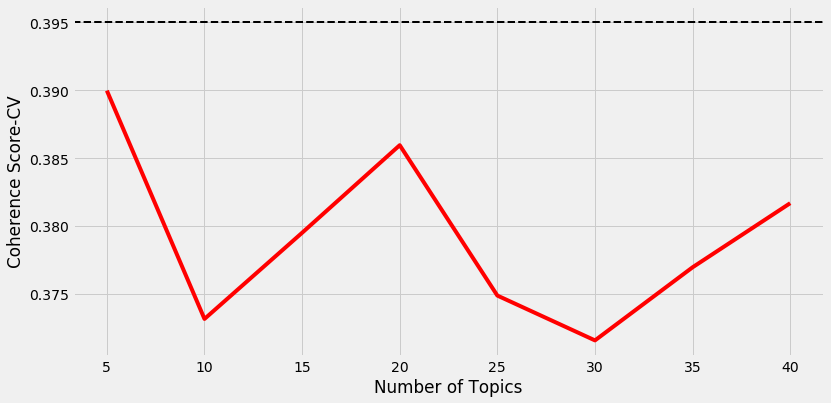

In [53]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

avg_coherence_cv_list = list

#x_ax = num_of_topics = [4, 6, 8, 10, 12, 14, 16, 18, 20]
x_ax = num_of_topics = [5, 10, 15, 20, 25, 30, 35, 40]
y_ax = metrics_df.Coh_CV

end=45; start=5; step=5;
x = range(start, end, step)

plt.figure(figsize=(12, 6))
plt.plot(x, y_ax, c = 'r')
plt.axhline(y=0.395, c = 'k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score-CV')

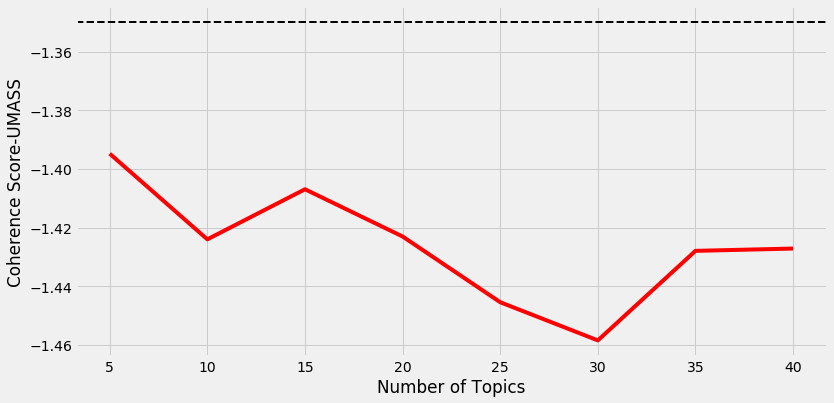

In [55]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

#x_ax = num_of_topics = [4, 6, 8, 10, 12, 14, 16, 18, 20]
x_ax =  [5, 10, 15, 20, 25, 30, 35, 40]
y_ax = metrics_df.Cov_UMASS

end=45; start=5; step=5;
x = range(start, end, step)

plt.figure(figsize=(12, 6))
plt.plot(x, y_ax, c = 'r')
plt.axhline(y=-1.35, c = 'k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score-UMASS')

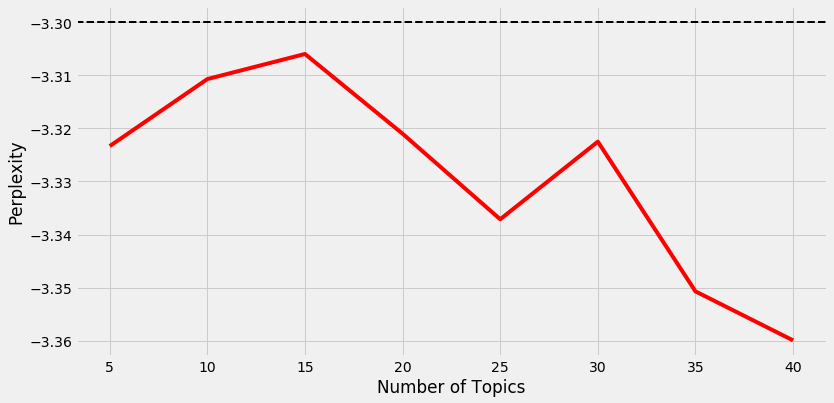

In [57]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

x_ax = num_of_topics = [4, 6, 8, 10, 12, 14, 16, 18, 20]
x_ax =  [5, 10, 15, 20, 25, 30, 35, 40]
y_ax = metrics_df.Perplexity

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c = 'r')
plt.axhline(y=-3.3, c = 'k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Perplexity')

In [28]:
for perf in gensim_perf:
    print(f"No_of_Topics = = {perf[0]}, avg_coh_cv = {perf[1]}, avg_coh_umass = {perf[2]}, perplexity = {perf[3]}")

No_of_Topics = = 5, avg_coh_cv = 0.3899733265745285, avg_coh_umass = -1.3947801735236611, perplexity = -3.323338230257643
No_of_Topics = = 10, avg_coh_cv = 0.3731753508523855, avg_coh_umass = -1.423964630266069, perplexity = -3.310702876564028
No_of_Topics = = 15, avg_coh_cv = 0.3795137194657018, avg_coh_umass = -1.4068982675846338, perplexity = -3.3059743167742877
No_of_Topics = = 20, avg_coh_cv = 0.3859574353435599, avg_coh_umass = -1.4229964241598492, perplexity = -3.321004078714127
No_of_Topics = = 25, avg_coh_cv = 0.37489476596824334, avg_coh_umass = -1.4453894948360055, perplexity = -3.3371268405887107
No_of_Topics = = 30, avg_coh_cv = 0.3715964951047674, avg_coh_umass = -1.4583969125116323, perplexity = -3.32249696488447
No_of_Topics = = 35, avg_coh_cv = 0.3769747006297408, avg_coh_umass = -1.4278868919634768, perplexity = -3.350714759162554
No_of_Topics = = 40, avg_coh_cv = 0.38169198952793043, avg_coh_umass = -1.427102062786848, perplexity = -3.3599544268054546


In [60]:
# Considering  above graphs we choose 20 as Optimal number of Topics


workers = 2
hyperParameters ={'corpus' : bow_docs, 
                 'id2word' : dictionary,
                 #'alpha' : 'auto', 
                 'chunksize' : 800000,
                 'eta' : 'auto',
                  'passes' : 10, 
                  'num_topics' : 20,
                  'random_state' : 42
                 }

evalParameters = { 'corpus' : bow_docs, 
                   'texts' : bigram_docs_corpus, 
                   'dictionary' : dictionary
                 }


lda_model = train_model(hyperParameters)
avg_coh_cv, avg_coh_umass, perplexity = evaluate_model(lda_model,evalParameters)

print("Number of Topics = 20" )
print(f"avg_coh_cv = {avg_coh_cv}/n, avg_coh_umass={avg_coh_umass}/n, perplexity={perplexity}/n")

------------ In Training ------------------------
Number of Topics = 20
avg_coh_cv = 0.38329506160256777/n, avg_coh_umass=-1.4351760027566174/n, perplexity=-3.2899982372394008/n


In [63]:
NO_OF_TOPICS = 20
topics = [[(term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=10)] for n in range(0, NO_OF_TOPICS)]

for idx, topic in enumerate(topics):
  print("Topic:", idx+1)
  print([term for term, wt in topic])
  print()

Topic: 1
['day', 'letter', 'dispute', 'time', 'account', 'credit', 'due', 'date', 'report', 'information']

Topic: 2
['name', 'account', 'amount', 'number', 'credit', 'report', 'information', 'due', 'time', 'balance']

Topic: 3
['payment', 'amount', 'balance', 'due', 'month', 'account', 'date', 'time', 'late', 'letter']

Topic: 4
['bank', 'payment', 'account', 'new', 'day', 'time', 'money', 'month', 'due', 'charge']

Topic: 5
['account', 'bank', 'card', 'service', 'time', 'credit', 'charge', 'money', 'day', 'year']

Topic: 6
['card', 'charge', 'credit', 'balance', 'account', 'letter', 'amount', 'month', 'time', 'bank']

Topic: 7
['information', 'dispute', 'month', 'credit', 'time', 'report', 'several', 'account', 'company', 'payment']

Topic: 8
['mortgage', 'payment', 'company', 'month', 'bank', 'account', 'letter', 'year', 'time', 'new']

Topic: 9
['consumer', 'information', 'reporting', 'agency', 'credit', 'report', 'account', 'date', 'request', 'service']

Topic: 10
['company', 'com